# Optimizing Deep Q-learning for Automated Doom using Data preprocessing, in Tensorflow 2.0. A Comparison of Stacking versus LSTM Approaches





## Training

First we import all the necessary libraries </font> 


In [1]:
#Visualization cobe for running within Colab

# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1



     |████████████████████████████████| 583kB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 46.0.0
    Uninstalling setuptools-46.0.0:
      Successfully uninstalled setuptools-46.0.0


In [2]:



%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

# Lua binding dependencies
apt-get install liblua5.1-dev


Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.4ubuntu1).
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
unzip is already the newest version (6.0-21ubuntu1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
git is already the newest version (1:2.17.1-1ubuntu0.5).
libbz2-dev is already the newest version (1.0.6-8.1ubuntu0.2).
libbz2-dev set to manually installed.
tar is already the newest version (1.29b-2ubuntu0.1).
The following additional packages will be installed:
  autoconf automake autopoint autotools-dev debhelper dh-autoreconf
  dh-strip-nondeterminism file freepats gettext gettext-base gir1.2-atk-1.0
  gir1.2-freedesktop gir1.2-gdkpixbuf-2.0 gir1.2-gtk-2.0 gir1.2-ibus-1.0
  gir1.2-pango-1.0 intltool-debian libarchive-cpio-perl li

In [3]:
#This will take 5 minutes
!pip install vizdoom



     |████████████████████████████████| 4.9MB 1.4MB/s 
  Created wheel for vizdoom: filename=vizdoom-1.1.7-cp36-none-any.whl size=14285793 sha256=4e874275e597a534b0228b93e39f8c447e14541e49426dfaf476c1749ac70743
  Stored in directory: /root/.cache/pip/wheels/67/98/04/d96d2c8edb8d1c008d926716257b407e56fb3ee0c81e51d25e
Successfully built vizdoom


In [4]:
#TF2 removed support for contrib layers, so we need to reinstall TF for 1.15
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 21kB/s 
     |████████████████████████████████| 512kB 41.5MB/s 
     |████████████████████████████████| 3.8MB 20.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f7d9295c13c2a00f66566ceec446f15d04ed7f856c40f7df8a40b19ab6fadf11
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc

In [5]:
import numpy as np
import vizdoom as vzd
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime

from IPython.display import HTML

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [6]:
print(tf.__version__)

1.15.0


In [0]:
"""
DELETE THIS?
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [8]:
#Demo demonstrating the game environment, with in-situ visualization for Colaboratory via recording at 25 fps


"""
from random import choice
import cv2 
from google.colab.patches import cv2_imshow
game = vzd.DoomGame()
    
# Load the correct configuration
game.load_config("/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.cfg")
    
# Load the correct scenario (in our case basic scenario)
game.set_doom_scenario_path("/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.wad")
#For Colaboratory application, sadly we cannot display the environment
game.set_screen_format(vzd.ScreenFormat.BGR24)
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
game.set_window_visible(False)
#Will this kill the image? or still run in background

game.set_render_hud(True)
game.set_render_minimal_hud(False)
game.init()


actions = [[True, False, False], [False, True, False], [False, False, True]]
episodes = 2
sleep_time = 0.028

img_array=[]
for i in range(episodes):
  
  print("Episode #"+str(i+1))
  game.new_episode()
  #original while not game.is_episode_finished() but for this approach we'll try something else
  t= 0
  while not game.is_episode_finished():
    state=game.get_state()

    #Fetch screen
    screen=state.screen_buffer
    print(screen.shape)
    #cv2_imshow(screen)
    cv2.waitKey(int(sleep_time * 1000))
    game.make_action(choice(actions))
    img_array.append(screen)
    
    
    print("State #" + str(state.number))
    print("=====================")
    #t+=1

  print("Episode finished!")
  print("************************")
  #We dont stop recording. We record at the very end only

#Writing Video section - maybe better to move to another cell

#See where this saves first. it may be possible we can still use show_video!
#As it seems to be searching globally



fps= 25
#need to figure out resolution of images  returned by buffer
#We should be able to do this by printing out the shape of the img_array, as its essentially x*y*n
resolution = (640,480)

VIDEO_STREAM_OUT = "/content/doom.mp4"

out = cv2.VideoWriter(VIDEO_STREAM_OUT,cv2.VideoWriter_fourcc(*'MP4V'), fps, resolution)
for i in range(len(img_array)):
    # writing to a image array
    out.write(img_array[i])
out.release()

"""


'\nfrom random import choice\nimport cv2 \nfrom google.colab.patches import cv2_imshow\ngame = vzd.DoomGame()\n    \n# Load the correct configuration\ngame.load_config("/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.cfg")\n    \n# Load the correct scenario (in our case basic scenario)\ngame.set_doom_scenario_path("/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.wad")\n#For Colaboratory application, sadly we cannot display the environment\ngame.set_screen_format(vzd.ScreenFormat.BGR24)\ngame.set_screen_resolution(vzd.ScreenResolution.RES_640X480)\ngame.set_window_visible(False)\n#Will this kill the image? or still run in background\n\ngame.set_render_hud(True)\ngame.set_render_minimal_hud(False)\ngame.init()\n\n\nactions = [[True, False, False], [False, True, False], [False, False, True]]\nepisodes = 2\nsleep_time = 0.028\n\nimg_array=[]\nfor i in range(episodes):\n  \n  print("Episode #"+str(i+1))\n  game.new_episode()\n  #original while not game.is_episo

In [0]:
#Load Game

import random                
import time
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

def initialize():
    game = vzd.DoomGame()
    
    # Load the correct configuration
    game.load_config("/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.cfg")
    
    # Load the correct scenario (in our case basic scenario)
    game.set_doom_scenario_path("/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.wad")
    #For Colaboratory application, sadly we cannot display the environment
    game.set_screen_format(vzd.ScreenFormat.BGR24)
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    

    game.set_render_hud(True)
    game.set_render_minimal_hud(False)
    game.set_window_visible(False)
    game.init()
    
    # Vector mapping of our actions for this scenario
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    possible_actions = [left, right, shoot]
    
    return game, possible_actions
       



In [0]:
#We'll initialize our doom environment here
game, possible_actions = initialize()

Now we define a preprocessing function for our input game screens. We crop the image size, removing some of the vertical elements in particular, and then convert them into a 1D tensor.



In [0]:
color = np.array([210, 164, 74]).mean()
from skimage import transform
from skimage.color import rgb2gray

#prepro (210, 160, 3) uint8 frame into 7040 (88x80) 1D float vector 

#Greyscale is already don in config, only cropping and pixel normalization
def preprocess_observation(frame):

    # Crop and resize the image into a square, as we don't need the excess information
    cropped = frame[60:-60,30:-30]

    normalized = cropped/255.0

    # Improve image contrast See if works
    #img[img==color] = 0

    # Next we normalize the image from -1 to +1 See if works
    #img = (img - 128) / 128 - 1

    
    img_gray = rgb2gray(normalized)

    preprocessed_frame = transform.resize(img_gray, [84,84])

    return preprocessed_frame


Let us initialize our gym environment, and take a look at some observations. Let's also inspect the size and type of action space in this game.

Episode #1
Episode #2


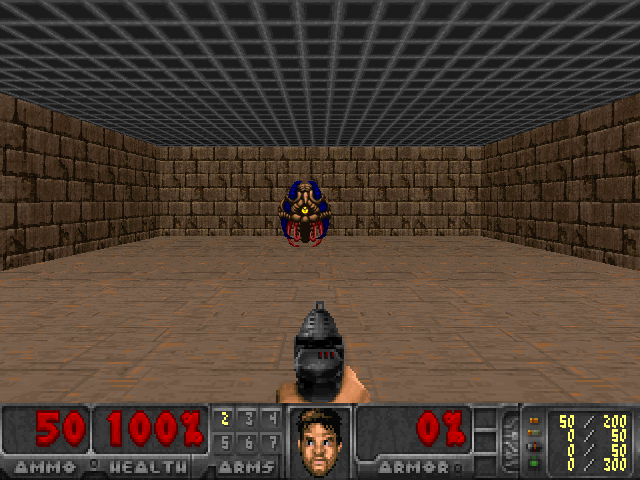

old shape: (480, 640, 3) , new shape: (84, 84)


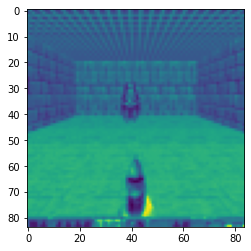

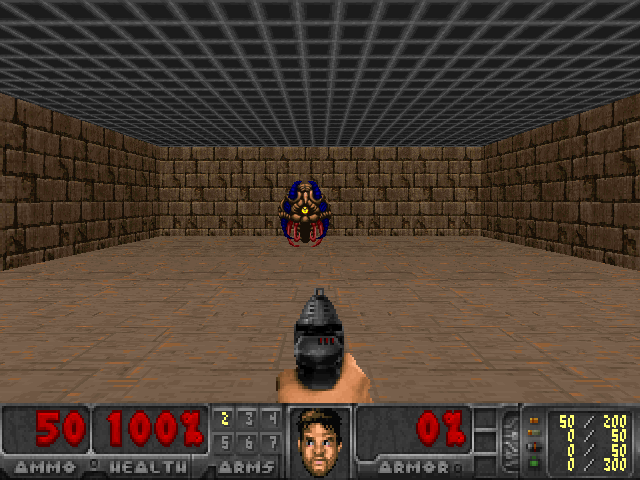

old shape: (480, 640, 3) , new shape: (84, 84)


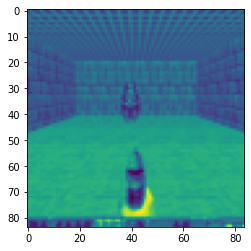

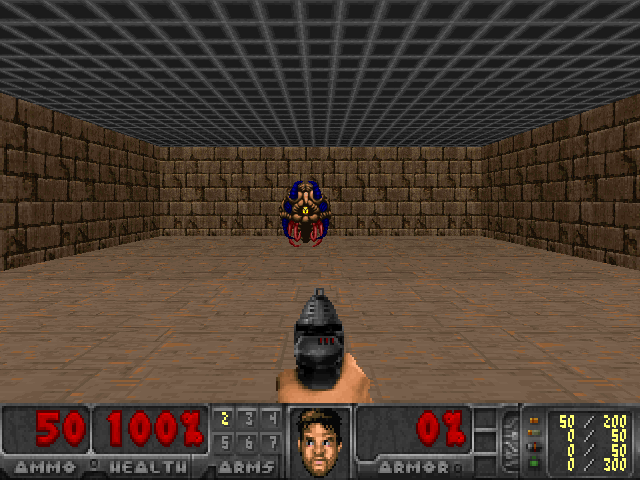

old shape: (480, 640, 3) , new shape: (84, 84)


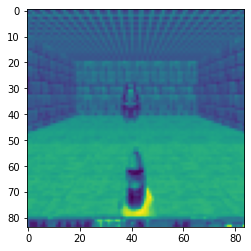

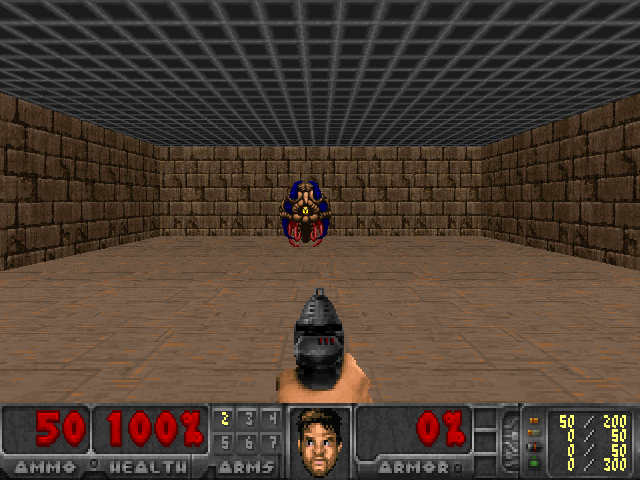

old shape: (480, 640, 3) , new shape: (84, 84)


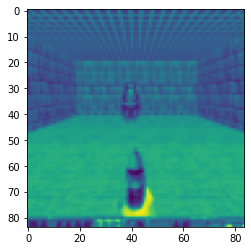

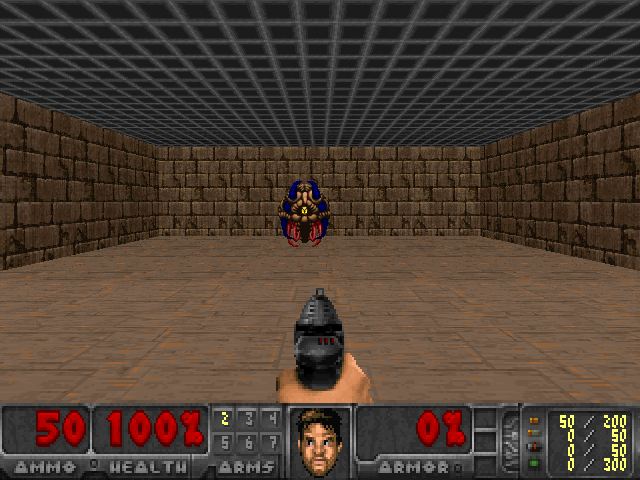

old shape: (480, 640, 3) , new shape: (84, 84)


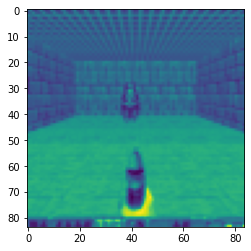

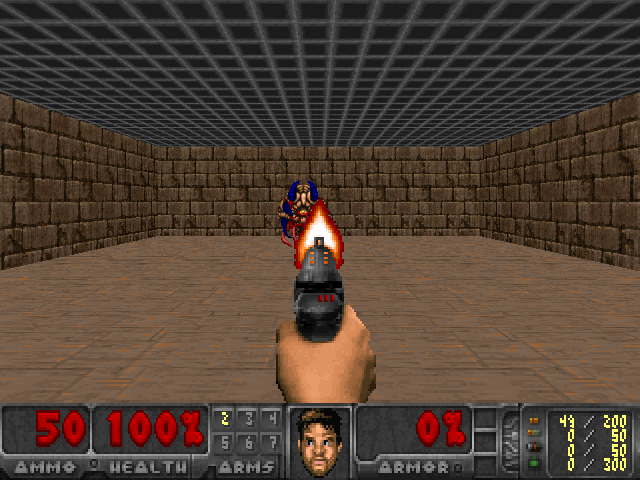

old shape: (480, 640, 3) , new shape: (84, 84)


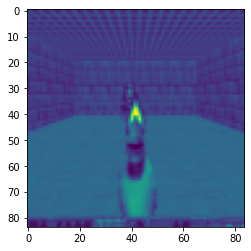

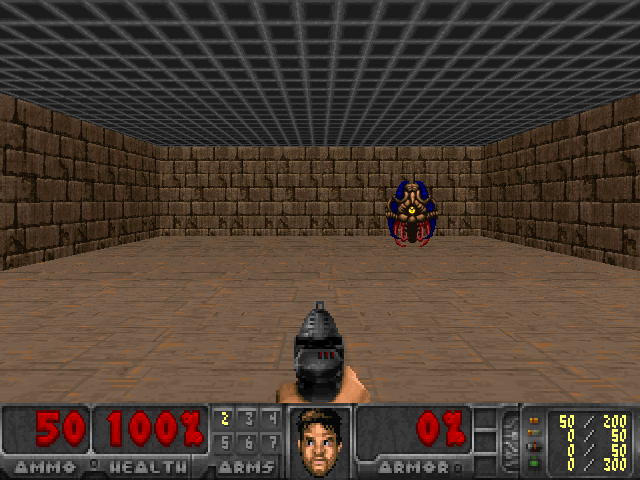

old shape: (480, 640, 3) , new shape: (84, 84)


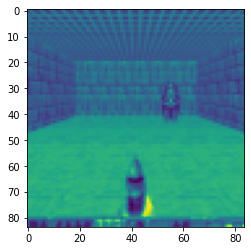

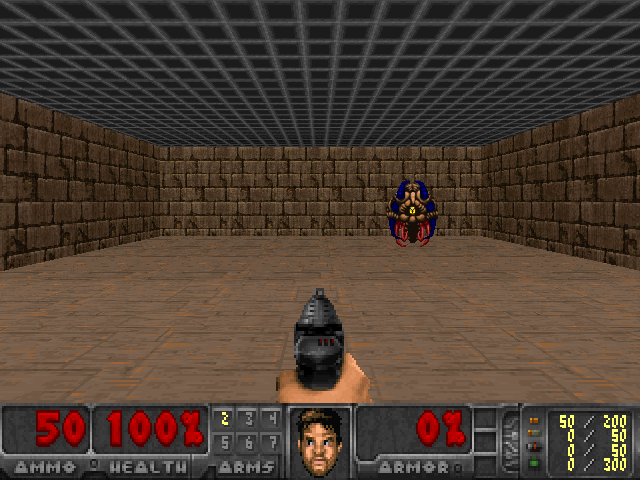

old shape: (480, 640, 3) , new shape: (84, 84)


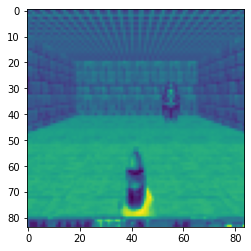

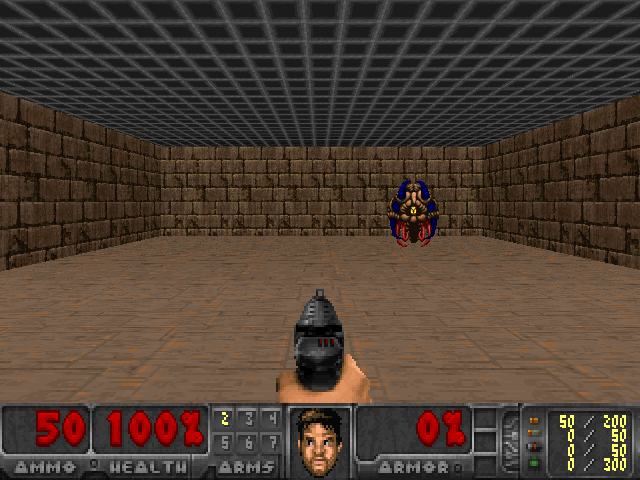

old shape: (480, 640, 3) , new shape: (84, 84)


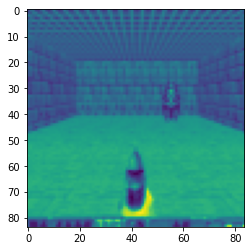

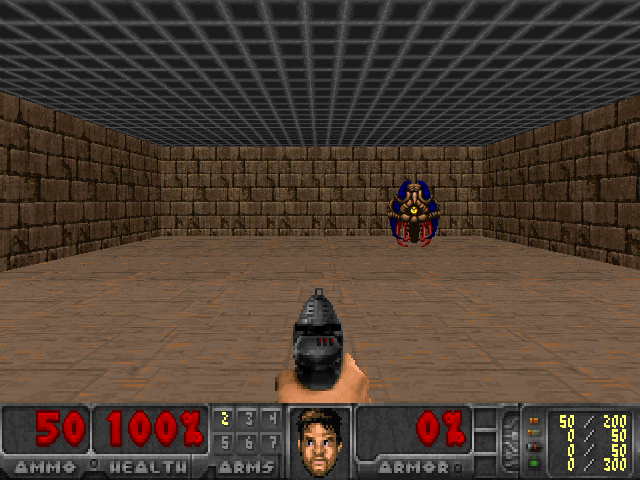

old shape: (480, 640, 3) , new shape: (84, 84)


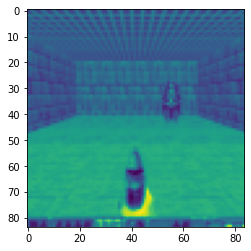

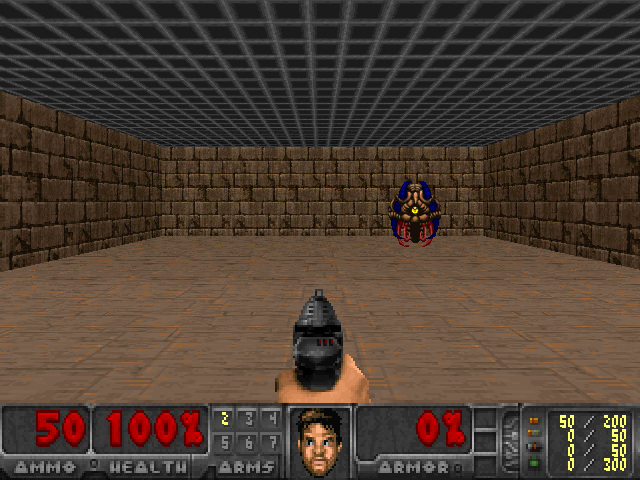

old shape: (480, 640, 3) , new shape: (84, 84)


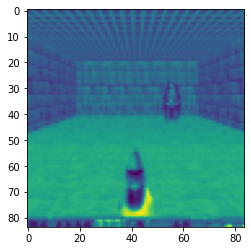

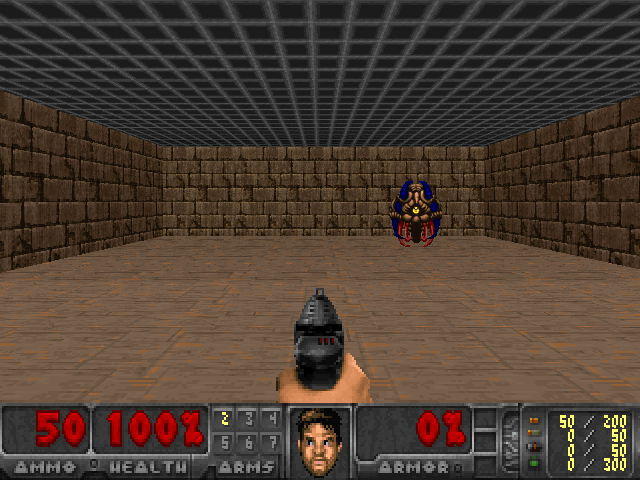

old shape: (480, 640, 3) , new shape: (84, 84)


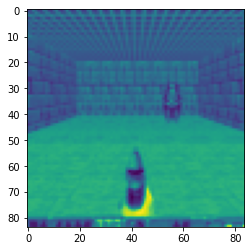

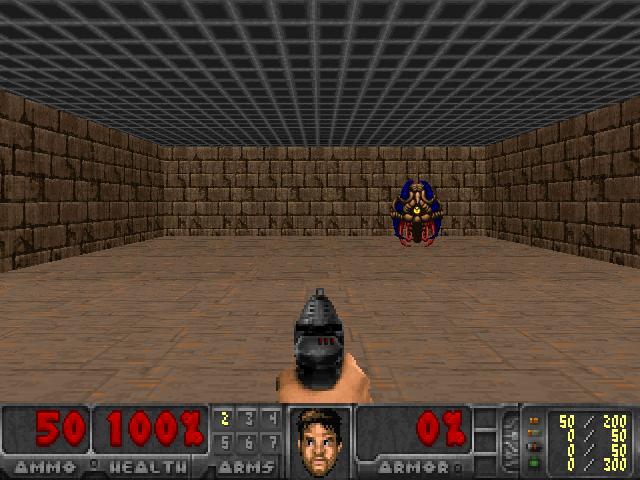

old shape: (480, 640, 3) , new shape: (84, 84)


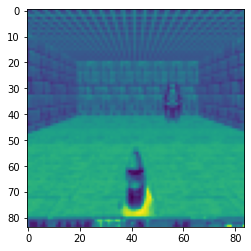

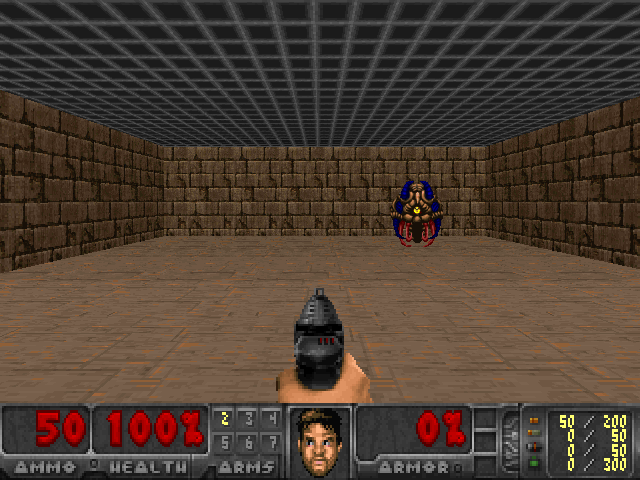

old shape: (480, 640, 3) , new shape: (84, 84)


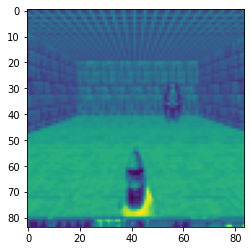

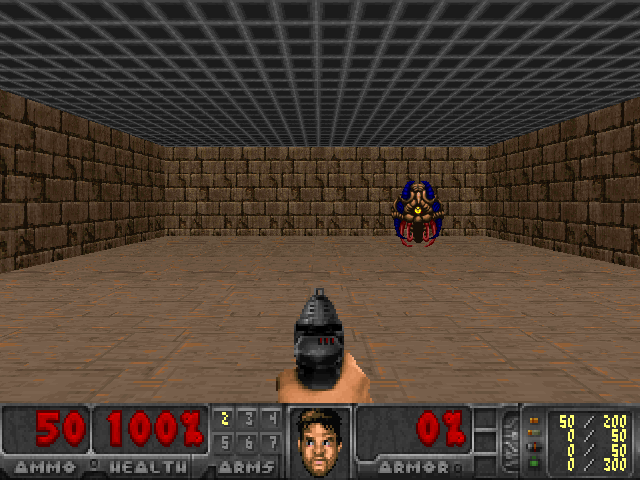

old shape: (480, 640, 3) , new shape: (84, 84)


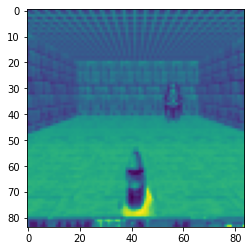

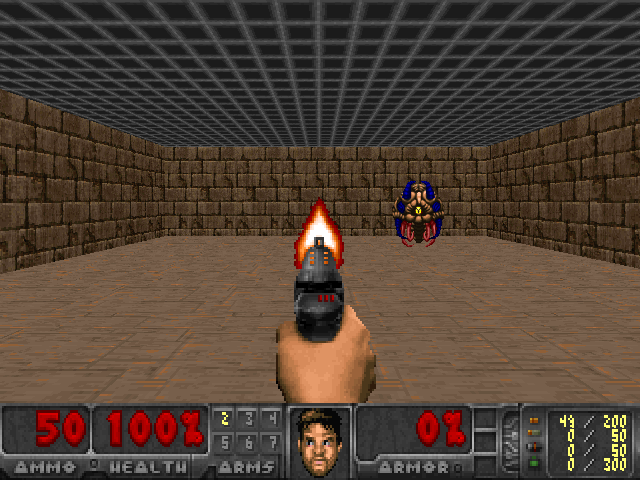

old shape: (480, 640, 3) , new shape: (84, 84)


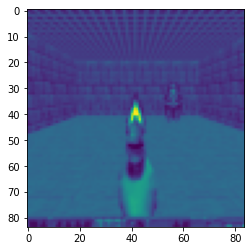

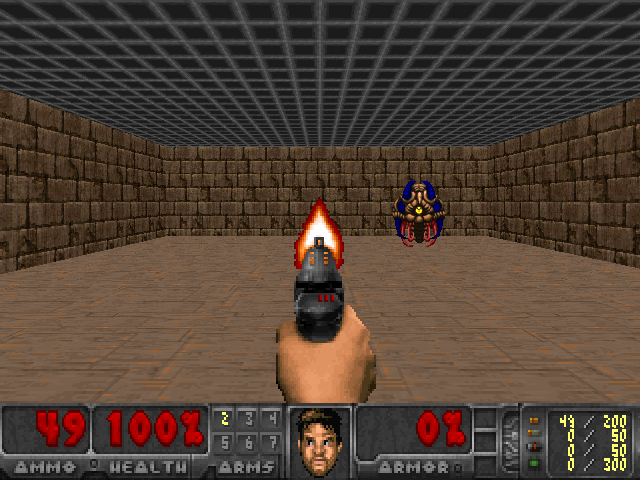

old shape: (480, 640, 3) , new shape: (84, 84)


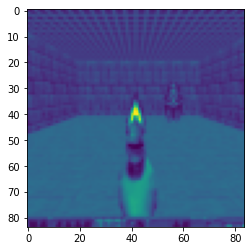

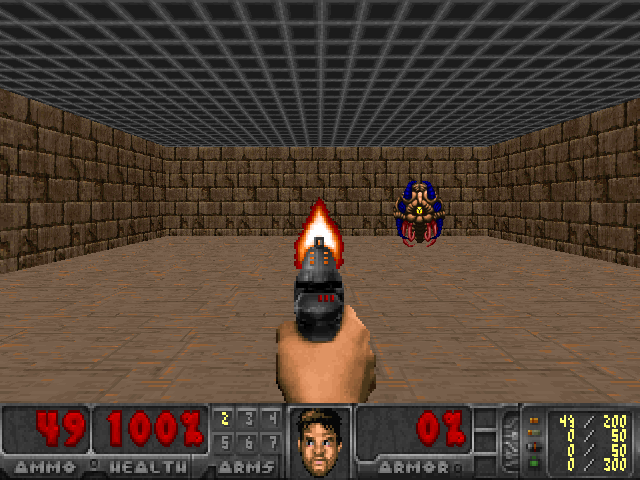

old shape: (480, 640, 3) , new shape: (84, 84)


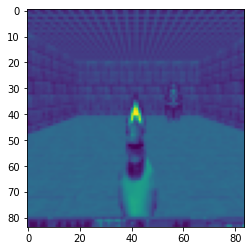

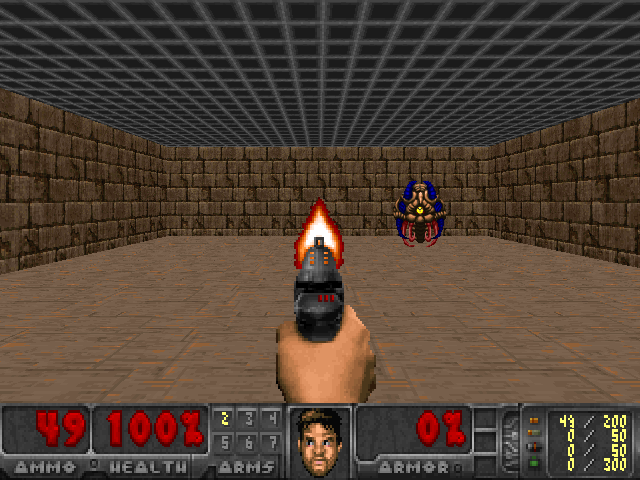

old shape: (480, 640, 3) , new shape: (84, 84)


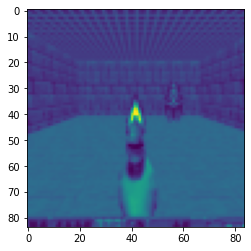

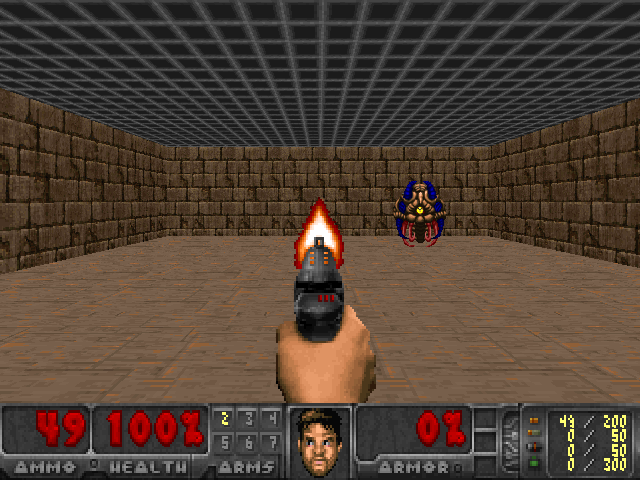

old shape: (480, 640, 3) , new shape: (84, 84)


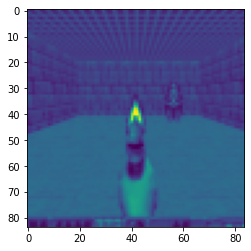

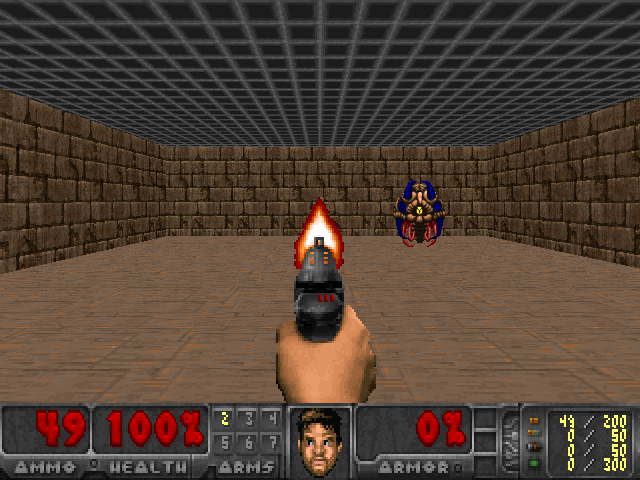

old shape: (480, 640, 3) , new shape: (84, 84)


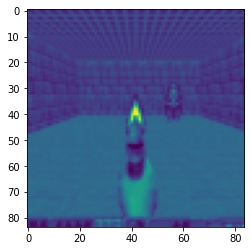

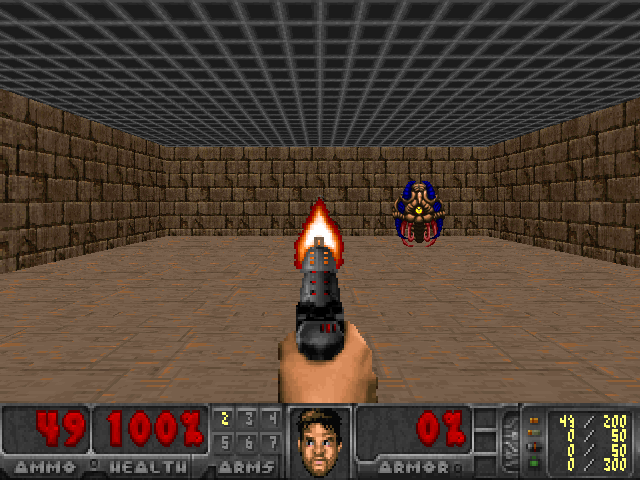

old shape: (480, 640, 3) , new shape: (84, 84)


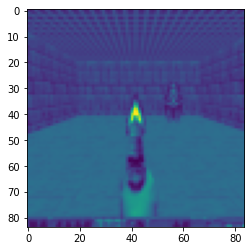

In [12]:
#View raw frames of data
from random import choice
import cv2 
from google.colab.patches import cv2_imshow
img_array=[]
actions = [[True, False, False], [False, True, False], [False, False, True]]
episodes = 2
sleep_time = 0.028
for i in range(episodes):
  
  print("Episode #"+str(i+1))
  game.new_episode()
  #original while not game.is_episode_finished() but for this approach we'll try something else
  t= 0
  while not game.is_episode_finished():
    state=game.get_state()

    #Fetch screen
    screen=state.screen_buffer
    
    #cv2_imshow(screen)
    cv2.waitKey(int(sleep_time * 1000))
    game.make_action(choice(actions))
    img_array.append(screen)

import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import misc



for i in range(22):
  
  
  cv2_imshow(img_array[i])
  new_frame = preprocess_observation(img_array[i])
  print("old shape: "+str(img_array[i].shape)+" , new shape: "+str(new_frame.shape))
  plt.imshow(new_frame)
  plt.show()


  

In [0]:
#Frame Stacking, used to supply another minibatch within a minibatch, in order to judge motion. orginally in deepmind paper
#Basically, as long as we always use stacks for all steps, and are consistent, there will not be any significant gaps in frequency

"""
We have all these frames, but what gets fed as input to the “Q-Network”? Paper used
 a sequence of four game frames stacked together, making the data dimension (4,84,84). 
 The idea is that the action agents choose depends on the prior sequence of game frames. 
 Imagine playing Breakout, for instance. Is the ball moving up or down? 
 If the ball is moving down, you better get the paddle in position to bounce it back up. 
 If the thatball is moving up, you can wait a little longer or try to move in the opposite direction as needed if you think the ball will eventually reach there.

Due to the way that some games (especially Atari) renders screens, every other frame may not aactually be rendered.
This is negatively affecting our performance, so instead, we take Deepmind's approach of element wise maxima
Create stack of 4, with 2 images combined via elementwise-maxima

"""


stack_size = 4 # We stack 4 composite frames in total

# Initialize deque with zero-images one array for each image. Deque is a special kind of queue that deletes last entry when new entry comes in
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_observation(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x, apply elementwise maxima
        
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        #Since deque append adds t right, we can fetch rightmost element
        #maxframe=np.maximum(stacked_frames[-1],frame)
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

Okay, Now we define a function called q_network for building our Deep Q network.  <br>
We build Q network with three convolutional layers with same padding followed by a flattening, and a fully connected layer.
This will convert our input frames into actionable outputs.

In [0]:
tf.compat.v1.reset_default_graph()
#Reset is technically not necessary if variables done  in TF2
#https://github.com/ageron/tf2_course/issues/8

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope: 


        # initialize the convolutional layers
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = flatten(layer_3)
        # Insert fully connected layer
        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)
        #Add final output layer. 3 actions here , left, right , shoot
        output = fully_connected(fc, num_outputs=3, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        

        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        #Return both variables and outputs together
        return vars, output

Next we define a function called epsilon_greedy for performing epsilon greedy policy.

In epsilon greedy policy we either select the best action with probability [1 - epsilon] or a random action with
probability [epsilon].


We use decaying epsilon greedy policy where value of epsilon will be decaying over time as we don't want to explore
forever. So over time our policy will be exploiting only good actions.




In [0]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

#
def epsilon_greedy(action, step,pos_act):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if p< epsilon:
      #dont use np.choice, just use random choice, as np choice needs 1 dimensional input
      #game.make_action(choice(actions))
        return choice(pos_act)
    else:
      #Otherwise,we take the fed highest argmax
        return pos_act[int(action)]

Now, we initialize our  buffer of length 20000 which holds the gameplay information in SARSA.

We store all the agent's experience i.e (state, action, rewards) in the experience replay buffer
and  we sample from this minibatch of experience for generating the y-values for the update function, and hence train the network.



In [0]:
buffer_len = 1000000 
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)



Next, we define a function called sample_memories for sampling experiences from the memory according to batches. Batch size is the number of experience sampled
from the memory. We'll also avoid an empty memory problem by pre-sampling our game environment


In [0]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]


Now we define our network hyperparameters,

In [0]:
#Check if Max Steps is actually needed, we've parameters at bottom too
num_episodes = 500
max_steps= 100

batch_size = 48
n_outputs = 3

input_shape = (None, 84, 84, 1)
#Recall shape is img.reshape(84,84,1)
learning_rate = 0.001
#Modified for composite stacked frames
X_shape = (None, 84, 84, 4)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [0]:
logdir = 'logs'
tf.compat.v1.reset_default_graph()

# Now we define the placeholder for our input i.e game state,  in this case (None, 84, 84, 4)
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

 Now let us build our primary and target Q network We have two networks to allow for training and data generation to occur concurrently.
 Note that the network returns the weights, as well as network outputs. 

In [20]:
# we build our Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [0]:
# define the placeholder for our action values

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)


Copy the primary Q network parameters to the target  Q network

In [0]:

copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)


Compute and optimize loss using gradient descent optimizer


In [0]:
# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())


 Now we start the tensorflow session and run the model,

1. First, we preprocess and feed the game screen (state s) to our DQN, which will
return the Q values of all possible actions in the state.
2. Now we select an action using the epsilon-greedy policy: with the probability
epsilon, we select a random action a and with probability 1-epsilon, we select an
action that has a maximum Q value, such as .
3. After selecting the action a, we perform this action in a state s and move to a new
state s' and receive a reward. The next state, s', is the preprocessed image of the
next game screen.
4. We store this transition in our replay buffer as <s,a,r,s'>.
5. Next, we sample some random batches of transitions from the replay buffer and
calculate the loss.

6. We know that the loss is defined as the squared
difference between target Q and predicted Q.

7. We perform gradient descent with respect to our actual network parameters in
order to minimize this loss.

8. Copy weights of training network to actual network
9. Repeat for M steps

Epochs here exist because we are suplying data in batches.

In [24]:


#Reset game as we have been exploring previous episodes for inspection

game, possible_actions = initialize()

with tf.compat.v1.Session() as sess:
    
    #Initiliaze global variables
    init.run()
    history = []
    
    # for each episode
    # history = []
    #Moved game episode here
    game.new_episode()
    for i in range(num_episodes):
        #game.new_episode() moved game episode to before numepisode check
        
        done = game.is_episode_finished()
        #Fetch screen/state
        
        obs = game.get_state().screen_buffer
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []
        intra_reward=[]
        step=0
        #First step, begin stacking frames
        obs,stacked_frames= stack_frames(stacked_frames,obs,True)

        #Start intra-episode training, keep count of steps
        while step<max_steps:
            step+=1
        
        

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            #increment the number of actions
            actions_counter[str(action)] += 1 

            #Recall possible actions  = [left, right, shoot], need to feed it to epsilon_greedy
            # Recall epsilon_greedy takes the predicted action, and compares
            # Against a set probability
            action = epsilon_greedy(action, global_step,possible_actions)
            
            
            # now perform the action and move to the next state, next_obs, receive reward
            reward = game.make_action(action)
            #Append current intra-episodic reward to a counter
            episodic_reward +=reward
            
            global_step += 1
            #After our action, we need to check if episode is done
            done = game.is_episode_finished()

            #if finished, next observation is zeroes.
            if done:

              """
              Essentially we have to avoid stacking in Done

              The original code was like this
              next_obs=np.zeros(obs.shape)
              exp_buffer.append([state, action, next_state, reward, done])
              state= game.get_state().screen_buffer (originally env.reset()) 
              state,stacked_frames= stack_frames(stacked_frames,state,True)

              The error('Cannot warp empty image with dimensions', (0, 24))
              arises due to scikit-image's transform. We cant transform anything.

              So looking at the orignal solution, we should probably call game.newepisode() here, and
              or alternatively, only have the lines:

              next_obs=np.zeros(obs.shape) # maybe 84 x 84 no idea
              exp_buffer.append([state, action, next_state, reward, done])

              As newepisode and initialstacking is always done at top. Note in original we had stacking with True parameter twice. Not a problem really
              
              Try things out!


              ###### Code before modifying
              next_obs=np.zeros(obs.shape)
              
              next_obs,stacked_frames= stack_frames(stacked_frames,next_obs,False)
              step = max_steps
              history.append(episodic_reward)
              print('Episode: {}'.format(len(history)),
                              'Total reward: {}'.format(episodic_reward),
                              'Training loss: {:.4f}'.format(episodic_loss))

              exp_buffer.append([obs, action, next_obs, reward, done])

              ####### Update 2803
              We can now train for a few epochs, however, afterwards we have another error.
              See the error box below for more information.
              I suspect it has something to do with either the buffer length, or the stacking frames
              Anyhow, progress!

              #Attemted to set done stackFrames to False: Nothing
              # Increased length of deque seems to have some but still nothing permanent.
              # Next step is to check what stack frames does in original 

              #When we do face an error, which cell do we need reset to get it to work? All the way in Deque

              #What if we simply start a new episode, and do nothing with observations? Same errorabout sequences

              """

              #next_obs=np.zeros((84,84), dtype=np.int)
              #next_obs,stacked_frames= stack_frames(stacked_frames,next_obs,False)
              
              #exp_buffer.append([obs, action, next_obs, reward, done])
              
              step = max_steps
              history.append(episodic_reward)
              print('Episode: {}'.format(len(history)),
                              'Total reward: {}'.format(episodic_reward))
              #obs = game.get_state().screen_buffer
              #obs,stacked_frames= stack_frames(stacked_frames,obs,True)
              game.new_episode()
              

              

            #Episode not done, continue sampling, fetch observations
            else:
              next_obs = game.get_state().screen_buffer
              next_obs, stacked_frames = stack_frames(stacked_frames, next_obs, False)
              exp_buffer.append([obs, action, next_obs, reward, done])
              obs = next_obs
              

            
            # After certain steps, we train our Q network with samples from the experience replay buffer.
            # Recall we have two networks in parallel, so one is purely for predicting while one is for training
            if global_step % steps_train == 0 and global_step > start_steps:
                #Our buffer should already contain everything preprocessed and stacked
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network. This means
            # That our sampling will also get better
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            
        """
        next_obs=np.zeros(obs.shape)
        exp_buffer.append([state, action, next_state, reward, done])
        state= game.get_state().screen_buffer 
        state,stacked_frames= stack_frames(stacked_frames,state,True) 
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))
    
        """

        


Episode: 1 Total reward: -130.0
Episode: 2 Total reward: 94.0
Episode: 3 Total reward: -125.0
Episode: 4 Total reward: 63.0
Episode: 5 Total reward: -130.0
Episode: 6 Total reward: -125.0
Episode: 7 Total reward: 32.0
Episode: 8 Total reward: -125.0
Episode: 9 Total reward: 45.0


ValueError: ignored

In [0]:
!pip install gym-doom

In [0]:
"""
# Old code above for reference

#Reset game as we have been exploring previous episodes for inspection

game, possible_actions = initialize()

with tf.compat.v1.Session() as sess:
    
    #Initiliaze global variables
    init.run()
    
    
    # for each episode
    # history = []
    for i in range(num_episodes):
        game.new_episode()
        
        done = game.is_episode_finished()
        #Fetch screen/state
        
        obs = game.get_state().screen_buffer
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []
        #First step, begin stacking frames
        
        obs,stacked_frames= stack_frames(stacked_frames,obs,True)

        

        # while the state is not the terminal state
        while done !=None:
          

           #Data generation using the untrained network
        
            

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            #Recall possible actions  = [left, right, shoot], need to feed it to epsilon_greedy
            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            
            # now perform the action and move to the next state, next_obs, receive reward
            reward = game.make_action(possible_actions[int(action)])
            
            next_obs=game.get_state().screen_buffer

            

            #Begin stacking intra-episode code
            next_obs, stacked_frames = stack_frames(stacked_frames, next_obs, False)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, next_obs, reward, done])
            done = game.is_episode_finished()
            # After certain steps, we train our Q network with samples from the experience replay buffer.
            # Recall we have two networks in parallel, so one is purely for predicting while one is for training
            if global_step % steps_train == 0 and global_step > start_steps:
                #Our buffer should already contain everything preprocessed and stacked
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs= next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward

        next_obs=np.zeros(obs.shape)
        exp_buffer.append([state, action, next_state, reward, done])
        state= game.get_state().screen_buffer 
        state,stacked_frames= stack_frames(stacked_frames,state,True) 
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))
    
"""

Let's plot our reward distribution across the incremental episodes. Remember to interrupt the training process first.

In [0]:
plt.plot(history)
plt.show()

## Evaluation

Finally, let's visualize our agent's performance, and play a game within the gym environment itself.

In [0]:
#Visualization cobe for running within Colab

# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1



In [0]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display



from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
#Evaluation should work. The only main difference is the problem of the network output itself,
#But given that its np.argmax should be fine




prev_input = None
img_array = []
with tf.compat.v1.Session() as sess:
    game, possible_actions = initialize()
    totalScore = 0
    
    #Single episode
    for i in range(1):
        
        done = False
        game.newEpisode()
    
        #set input to network to be difference image
        observation = game.get_state().screen_buffer
        img_array.append(observation)
        observation, stacked_frames = stack_frames(stacked_frames, observation, True)
    
        
        #print(observation.shape)
        
        while not game.is_episode_finished():


          # feed the game screen and get the Q values for each action
          actions = mainQ_outputs.eval(feed_dict={X:[observation], in_training_mode:False})

          # get the action
          action = np.argmax(actions, axis=-1)
          actions_counter[str(action)] += 1 

          """
          2803
          Epsilon Greedy and action selection need to be modded properly

          """
          # select the action using epsilon greedy policy
          action = epsilon_greedy(action, global_step)

          game.make_action(action)
          done = game.is_episode_finished()
         
          score = game.get_total_reward
          if done: 
            #observation = env.reset()
            break
          else:
            print("else")
            next_obs= game.get_state().screen_buffer
            next_obs, stacked_frames = stack_frames(stacked_frames, next_state, False)
            observation = next_observation
            img_array.append(observation)
      
        score = game.get_total_reward()
        print("Score: ", score)
    game.close()  

    fps= 25
#need to figure out resolution of images  returned by buffer
#We should be able to do this by printing out the shape of the img_array, as its essentially x*y*n
resolution = (640,480)

VIDEO_STREAM_OUT = "/content/doom.mp4"

out = cv2.VideoWriter(VIDEO_STREAM_OUT,cv2.VideoWriter_fourcc(*'MP4V'), fps, resolution)
for i in range(len(img_array)):
    # writing to a image array
    out.write(img_array[i])
out.release()

In [0]:
"""
OLD CODE
#Evaluate model on openAi GYM


environment = wrap_env(gym.make('SpaceInvaders-v0'))
done = False
observation = environment.reset()
new_observation = observation

prev_input = None

with tf.compat.v1.Session() as sess:
    init.run()
    observation, stacked_frames = stack_frames(stacked_frames, observation, True)
    while True:
       
    
        #set input to network to be difference image
  
        
        #print(observation.shape)
        
        

        # feed the game screen and get the Q values for each action
        actions = mainQ_outputs.eval(feed_dict={X:[observation], in_training_mode:False})

        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 

        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
        environment.render()
        new_observation, stacked_frames = stack_frames(stacked_frames, new_observation, False)
        
        observation = new_observation        
        # now perform the action and move to the next state, next_obs, receive reward
        new_observation, reward, done, _ = environment.step(action)
        
        if done: 
          #observation = env.reset()
          break
      
    environment.close()
    show_video()
"""